# Introduction
This notebook is for CSE-4111 lab and to be submitted to the [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic/overview) competetion from Kaggle. 

*This submission has managed to achieve score >= 80th percentile in the leaderboard*

## Steps we follow:
- First we setup our environment in google collab and load input csv files. Both input and output CSV files are kept in personal drive so that they're persistent.
- Then we move on to describing, summarizing the data in various ways to learn more about different features
- We then have to cleanup missing values in our data and do some feature engineering to learn extra information that can be extracted from the given data
- We then train our model using [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) which maps the included features to chances of survival
- We then save the predictions and submit to the competetion to get a **maximum score of 78.229%***

> The code itself is understandable and well documented

# First, setting up the environment

In [68]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # For plotting a few figures
import warnings
import seaborn as sns # Also for plotting
warnings.simplefilter(action='ignore') # Ignore warnings of modules
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
plt.rc("font", size=14)

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Check out the data we are going to train on.

In [70]:
train_data = pd.read_csv("drive/MyDrive/google_colab_data/titanic_dataset/kaggle/input/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## And the data we are going to train on.

In [71]:
test_data = pd.read_csv("drive/MyDrive/google_colab_data/titanic_dataset/kaggle/input/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


> *First things first, let's check out if Rose, from the movie Titanic, is  in this data or not*

In [72]:
rose = train_data.loc[train_data['Name'].str.contains("Rose Dewitt Bukater", case=False) & train_data['Sex'].str.match('female')]
print("Rose exists in train_data: ", rose.size > 0)

Rose exists in train_data:  False


# Descriptions of dataset and variable initializations

In [73]:
first_class_passengers = train_data.loc[train_data['Pclass'] == 1]
second_class_passengers = train_data.loc[train_data['Pclass'] == 2]
third_class_passengers = train_data.loc[train_data['Pclass'] == 3]
surviving_first_class_passengers = first_class_passengers.loc[first_class_passengers['Survived'] == 1]
surviving_second_class_passengers = second_class_passengers.loc[second_class_passengers['Survived'] == 1]
surviving_third_class_passengers = third_class_passengers.loc[third_class_passengers['Survived'] == 1]
male_passengers = train_data.loc[train_data['Sex'] == 'male']
male_passengers_survived = male_passengers.loc[male_passengers['Survived'] == 1]
female_passengers = train_data.loc[train_data['Sex'] == 'female']
female_passengers_survived = female_passengers.loc[female_passengers['Survived'] == 1]
children_passengers = train_data.loc[train_data['Age'] < 16]
children_passengers_survived = children_passengers.loc[children_passengers['Survived'] == 1]
adult_passengers = train_data.loc[train_data['Age'] >= 16]
adult_passengers_survived = adult_passengers.loc[adult_passengers['Survived'] == 1]
	
print(f"List of genders in train data: {train_data['Sex'].unique()}")
print(f"Age range in train data: {train_data['Age'].min()} - {train_data['Age'].max()}")
print("Description of train data:")
train_data.describe()

List of genders in train data: ['male' 'female']
Age range in train data: 0.42 - 80.0
Description of train data:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Checking for missing values

In [74]:
# Missing values in train data
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [75]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

*As we can see, some of the data are missing*
> Why Is Data Missing From The Dataset <br> Online sources suggest that, there can be multiple reasons why certain values are missing from the data. <br> Reasons for the missing data from the dataset affect the approach of handling missing data. So it’s necessary to understand why the data could be missing. <br> 

Some of the reasons are listed below:
- Past data might get corrupted due to improper maintenance. 
- Observations are not recorded for certain fields due to some reasons. 
- There might be a failure in recording the values due to human error. 
- The user has not provided the values intentionally.

### Visualizing null values in the dataset

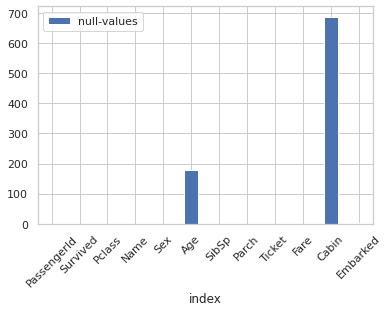

In [76]:
train_data.isna().sum().reset_index(name="null-values").plot.bar(x='index', y='null-values', rot=45)

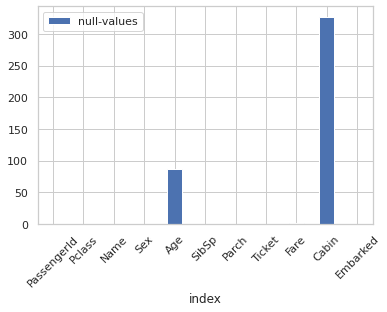

In [77]:
test_data.isna().sum().reset_index(name="null-values").plot.bar(x='index', y='null-values', rot=45)

### Check if there is any relation between missing age and gender

In [78]:
female_passengers_with_missing_age = female_passengers.loc[female_passengers["Age"].isna()]
male_passengers_with_missing_age = male_passengers.loc[male_passengers["Age"].isna()]
print(f"Missing age percentage among male: {100*len(male_passengers_with_missing_age)/len(male_passengers) : .2f}%, female: {100*len(female_passengers_with_missing_age)/len(female_passengers):.2f}%")

Missing age percentage among male:  21.49%, female: 16.88%


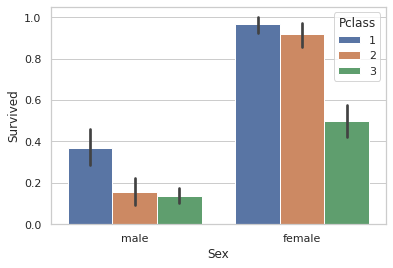

In [79]:
sns.barplot(x='Sex', y = 'Survived', hue='Pclass', data=train_data)

The graph suggests that in general, females survived more than male. Also Pclass has a contribution in survival as 1 means high class.

# Data cleanup and Feature Engineering

In [80]:
# Temporarily turning 'Sex' column into binary values (for both Train and Test data!)                
train_data_updated = train_data.copy() # copy train_data to train_data_updated
test_data_updated = test_data.copy() # copy test_data to test_data_updated

print(f"Train_data d-types:\n {train_data_updated.dtypes}")
print(f"\nTest_data d-types:\n {test_data_updated.dtypes}")

Train_data d-types:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Test_data d-types:
 PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [81]:
print(train_data_updated["Cabin"].unique())
print(f"train_data_updated mode:")
train_data_updated["Cabin"].mode()

[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148']
train_data_updated mode:


0        B96 B98
1    C23 C25 C27
2             G6
dtype: object

## Let's test out some assumptions
**Assumptions List:**
- First class passengers usually survived more
- Women and children survived more than men

In [82]:
# find correlation between features
train_data_updated_temp = train_data_updated.copy()
# train_data_updated_temp["SexBinary"] == 1 if train_data_updated_temp["Sex"] is 'male' else 0
train_data_updated_temp["isMale"] = np.where(train_data_updated_temp["Sex"] == "male", 1, 0)
corr = train_data_updated_temp.corr()
corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,isMale
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,0.042939
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.543351
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.131900
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.093254
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.114631
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.245489
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182333
isMale,0.042939,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,1.000000


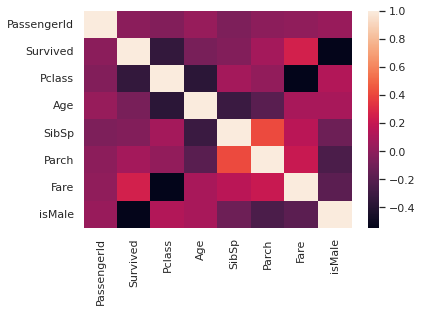

In [83]:
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

> No Strong Correlation between survival and any other feature,<br> but in general Female Passengers ('SexBinary' value = 0) have indeed survived more than Male ones. (Weak Correlation)<br> Also, there's strong correlation between Pclass and Fare. <br> And, there's a weak correlation between survival and passenger class. <br> Also, the negative correlation between 'Age' and 'Survival' suggests that older people survived less.

In [84]:
# print percentage of adult passengers who survived and percentage of children passengers who survived
print(f"Percentage of adult passengers ('Age'>=16) who survived: {100*len(adult_passengers_survived)/len(adult_passengers):.2f}%")
print(f"Percentage of children ('Age'<16) passengers who survived: {100*len(children_passengers_survived)/len(children_passengers):.2f}%")

# print percentage of male passengers who survived and percentage of female passengers who survived
print(f"Percentage of 'male' passengers who survived: {100*len(male_passengers_survived)/len(male_passengers):.2f}%")
print(f"Percentage of 'female' passengers who survived: {100*len(female_passengers_survived)/len(female_passengers):.2f}%")

# print percentage of first class passengers who survived and percentage of second class passengers who survived and percentage of third class passengers who survived
print(f"Percentage of first class passengers who survived: {100*len(surviving_first_class_passengers)/len(first_class_passengers):.2f}%")
print(f"Percentage of second class passengers who survived: {100*len(surviving_second_class_passengers)/len(second_class_passengers):.2f}%")
print(f"Percentage of third class passengers who survived: {100*len(surviving_third_class_passengers)/len(third_class_passengers):.2f}%")


Percentage of adult passengers ('Age'>=16) who survived: 38.19%
Percentage of children ('Age'<16) passengers who survived: 59.04%
Percentage of 'male' passengers who survived: 18.89%
Percentage of 'female' passengers who survived: 74.20%
Percentage of first class passengers who survived: 62.96%
Percentage of second class passengers who survived: 47.28%
Percentage of third class passengers who survived: 24.24%


### Men and Women

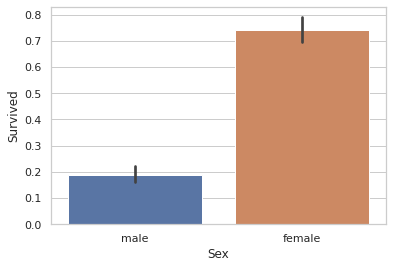

In [85]:
# bar chart of Sex as x axis and survival rate as y axis
sns.barplot(x="Sex", y="Survived", data=train_data_updated)

### Children
Now we will look at how the age of the passenger affected their chance of survival.


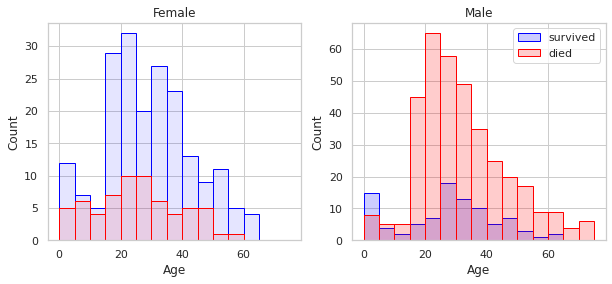

In [86]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10, 4))
women = train_data[train_data['Sex']=='female']
men = train_data[train_data['Sex']=='male']

ax = sns.histplot(women[women['Survived']==1].Age.dropna(), ax=axes[0], bins=range(0, 80, 5), label = 'survived', color='blue', edgecolor='blue', alpha=0.1)
ax = sns.histplot(women[women['Survived']==0].Age.dropna(), ax=axes[0], bins=range(0, 80, 5), label = 'died', color='red', edgecolor='red', alpha=0.1)

ax.set_title('Female')

ax = sns.histplot(men[men['Survived']==1].Age.dropna(), ax=axes[1], bins=range(0, 80, 5), label = 'survived',  color='blue', edgecolor='blue', alpha=0.2)
ax = sns.histplot(men[men['Survived']==0].Age.dropna(), ax=axes[1], bins=range(0, 80, 5), label = 'died', color='red', edgecolor='red', alpha=0.2)
ax.legend()
_ = ax.set_title('Male')

### Plcass wise survival

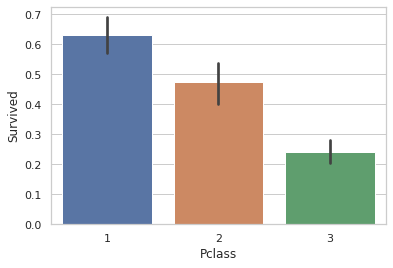

In [87]:
# bar chart of pClass as x axis and survival rate as y axis
sns.barplot(x="Pclass", y="Survived", data=train_data_updated)

### Understanding how to replace missing Ages 

In [88]:
# percent of missing "Age" 
print('Percent of missing "Age" records in Train Data is %.2f%%' %((train_data_updated['Age'].isnull().sum()/train_data_updated.shape[0])*100))
print('Percent of missing "Age" records in Test Data is %.2f%%' %((test_data_updated['Age'].isnull().sum()/test_data_updated.shape[0])*100))

Percent of missing "Age" records in Train Data is 19.87%
Percent of missing "Age" records in Test Data is 20.57%


### Let's look at the distribution of age values

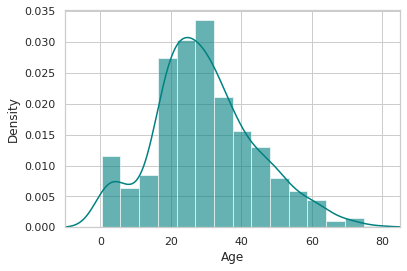

In [89]:
ax = train_data_updated["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_data_updated["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

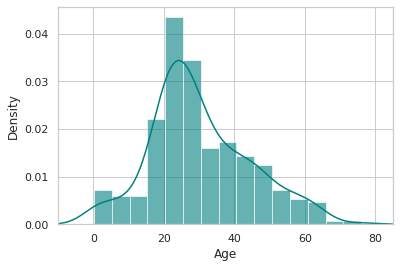

In [90]:
ax = test_data_updated["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
test_data_updated["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

Looking at the right skewed distribution and previous analysis, it's wrong to simply replace missing 'Age' values with a global median/mean.

### Port of embarkation

We have seen that sex, class of the passenger and age are variables affecting the survival chance of a passenger. Now let us look at the effect of the port of embarkation. 

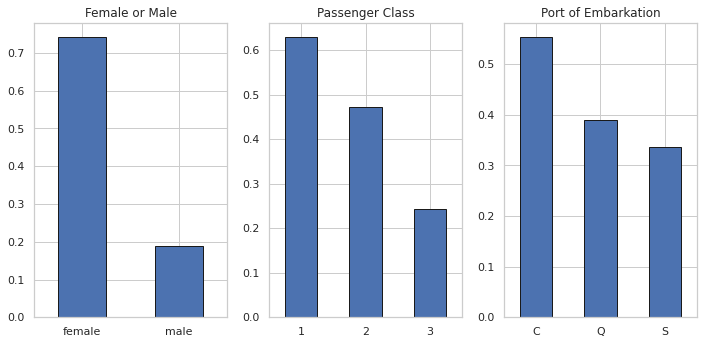

In [91]:
fig1, ax1 = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
train_data.groupby('Sex')['Survived'].mean().plot.bar(ax=ax1[0], rot=0, title='Female or Male', edgecolor="k", xlabel='')
train_data.groupby('Pclass')['Survived'].mean().plot.bar(ax=ax1[1], rot=0, title='Passenger Class', edgecolor="k", xlabel='')
train_data.groupby('Embarked')['Survived'].mean().plot.bar(ax=ax1[2], rot=0, title='Port of Embarkation', edgecolor="k", xlabel='')

plt.tight_layout()
plt.show()

Third plot is roughly showing how 'Port of Embarkation' = 'Cherbourg' has a higher rate of survival but not very high.

## Feature engineering

Having more features is not always advantageous, quite the opposite! Redundant and correlated features affects negatively the performance of the model. For example the variable "Fare" is highly correlated with the class and gender of the passenger, and has therefore a prective power, but it becomes redundant in a model already cointaing "class" and "sex". Especially in logistic regression, we aim at the simpler model that can explain the data. Therefore here we will limit our predictors to the following most informative variables:

- sex
- age
- class
- family size

We will create categorical variables to better represent these factors.

In [92]:
# Extract and then remove the targets from the training data 
targets = train_data.Survived
train_data.drop(['Survived'], axis=1, inplace=True)

# Merge train and test data for feature engineering
combined = train_data.append(test_data) 
combined.reset_index(inplace=True)

# Remove non informative features
combined.drop(['index','PassengerId','Name','Ticket','Cabin','Fare','Embarked'], axis=1, inplace=True) 

In [93]:
print(combined.shape)

(1309, 5)


In [94]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,male,22.0,1,0
1,1,female,38.0,1,0
2,3,female,26.0,0,0
3,1,female,35.0,1,0
4,3,male,35.0,0,0


### Age variable
The Age variable is missing a large number of values. Simply replacing them with the mean or the median age is not the best solution since the age differs by categories of passengers. 
Therefore, we will fill in the missing values on the base of both Sex and Class of the passenger.

In [95]:
print(combined.iloc[:891].Age.isnull().sum()) # Number of missing ages in train set

177


In [96]:
print(combined.iloc[891:].Age.isnull().sum()) # Number of missing ages in test set

86


For help with filling in missing ages with median based on Sex and Class.

In [97]:
grouped_train = combined.iloc[:891].groupby(['Sex','Pclass'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Age']]

In [98]:
grouped_median_train.head()

,Sex,Pclass,Age
0,female,1,35.0
1,female,2,28.0
2,female,3,21.5
3,male,1,40.0
4,male,2,30.0


First we create a function that fills in the missing age based on Sex and Class.

In [99]:
def fill_age(row):
    return grouped_median_train[(grouped_median_train['Sex'] == row['Sex']) & (grouped_median_train['Pclass'] == row['Pclass'])]['Age'].values[0]


def process_age():
    global combined
    # a function that fills the missing values of the Age variable
    combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    return combined

In [100]:
combined = process_age()
combined.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,male,22.0,1,0
1,1,female,38.0,1,0
2,3,female,26.0,0,0
3,1,female,35.0,1,0
4,3,male,35.0,0,0


For modeling the effect that age has on the chance of survival of a passenger, we introduce a categorical variable "AgeGroup" with levels Child (0-12 y.o.), Teenager (13-19 y.o.), Adult(>= 20 y.o.)

In [101]:
def process_age_group():
    
    global combined
    combined['Child'] = combined['Age'].map(lambda s: 1 if s <= 12 else 0)
    combined['Teenager'] = combined['Age'].map(lambda s: 1 if 13 <= s <= 19 else 0)
    combined['Adult'] = combined['Age'].map(lambda s: 1 if s >= 20 else 0)
    
    # removing "Age"
    combined.drop('Age',axis=1,inplace=True)
    
    return combined

In [102]:
combined = process_age_group()
combined.head()

,Pclass,Sex,SibSp,Parch,Child,Teenager,Adult
0,3,male,1,0,0,0,1
1,1,female,1,0,0,0,1
2,3,female,0,0,0,0,1
3,1,female,1,0,0,0,1
4,3,male,0,0,0,0,1


### Sex variable
This function maps the string values male and female to 1 and 0 respectively.

In [103]:
def process_sex():
    global combined
    # mapping string values to numerical one 
    combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})
    
    return combined

In [104]:
combined = process_sex()
combined.head()

,Pclass,Sex,SibSp,Parch,Child,Teenager,Adult
0,3,1,1,0,0,0,1
1,1,0,1,0,0,0,1
2,3,0,0,0,0,0,1
3,1,0,1,0,0,0,1
4,3,1,0,0,0,0,1


### PClass variable
This function encodes the values of Pclass (1,2,3) using a dummy encoding.

In [105]:
def process_pclass():
    
    global combined
    # encoding into 3 categories:
    pclass_dummies = pd.get_dummies(combined['Pclass'], prefix='Pclass')
    
    # adding dummy variable
    combined = pd.concat([combined, pclass_dummies],axis=1)
    
    # removing "Pclass"
    combined.drop('Pclass',axis=1,inplace=True)
    
    return combined

In [106]:
combined = process_pclass()
combined.head()

,Sex,SibSp,Parch,Child,Teenager,Adult,Pclass_1,Pclass_2,Pclass_3
0,1,1,0,0,0,1,0,0,1
1,0,1,0,0,0,1,1,0,0
2,0,0,0,0,0,1,0,0,1
3,0,1,0,0,0,1,1,0,0
4,1,0,0,0,0,1,0,0,1


### Family variable (From SibSp and Parch Values)

This function introduces 4 new features:
- FamilySize : the total number of relatives including the passenger (him/her)self.
- Sigleton : a boolean variable that describes families of size = 1
- SmallFamily : a boolean variable that describes families of 2 <= size <= 4
- LargeFamily : a boolean variable that describes families of size > 5

> The reason behind introducing a 'Family variable' is that we naturally expect a few people from large families to survive, specially if they're also from higher class and young.

In [107]:
def process_family():
    
    global combined
    # introducing a new feature : the size of families (including the passenger)
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
    # introducing other features based on the family size
    combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    
    # removing Parch and SibSp
    combined.drop('Parch',axis=1,inplace=True)
    combined.drop('SibSp',axis=1,inplace=True)
    combined.drop('FamilySize',axis=1,inplace=True)
    
    return combined

In [108]:
combined = process_family()
combined.head()

,Sex,Child,Teenager,Adult,Pclass_1,Pclass_2,Pclass_3,Singleton,SmallFamily,LargeFamily
0,1,0,0,1,0,0,1,0,1,0
1,0,0,0,1,1,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0
3,0,0,0,1,1,0,0,0,1,0
4,1,0,0,1,0,0,1,1,0,0


# Logistic Regression and Results

In [109]:
from sklearn.linear_model import LogisticRegression

### Reinitializing train, test, target split after combined feature engineering

In [110]:
def recover_train_test_target():
    global combined
    
    targets = pd.read_csv('drive/MyDrive/google_colab_data/titanic_dataset/kaggle/input/train.csv', usecols=['Survived'])['Survived'].values
    train = combined.iloc[:891]
    test = combined.iloc[891:]
    
    return train, test, targets

train, test, targets = recover_train_test_target()

In [111]:
clf = LogisticRegression(solver='liblinear')
clf = clf.fit(train, targets)

In [112]:
clf.score(train, targets)

0.8125701459034792

### Predicting and saving output to drive

In [113]:
output = clf.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('drive/MyDrive/google_colab_data/titanic_dataset/kaggle/input/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('drive/MyDrive/google_colab_data/titanic_dataset/kaggle/output/submission.csv', index=False)

In [114]:
df_output.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0
